In [7]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [8]:
df = pd.read_csv("Brownlow Full Database.csv")

def calculate_margin(row):
    if(row['Team'] == row['Home_Team']):
        return row['Home_Score'] - row['Away_Score']
    else:
        return row['Away_Score'] - row['Home_Score']
    
df = df.iloc[:, :-4]
df['Winning_Margin'] = df.apply(lambda x: calculate_margin(x), axis=1)
df = df.iloc[:, 10:]

# def sample_no_votes(row):
#     if row['Brownlow_Votes'] > 0:
#         return True
#     else:
#         return True if random.randint(0, 100) < 10 else False

    
# df['keep'] = df.apply(lambda x: sample_no_votes(x), axis=1)
# df_balanced = df.drop(df[df.keep == False].index)

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
X = df.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions', # values not recorded in 2012 data
    'Brownlow_Votes'
], axis=1).values

y = df['Brownlow_Votes'].fillna(0).values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
mlp = MLPClassifier(max_iter=1000)

#Train the model using the training sets
mlp.fit(X_train, y_train)

#Predict the response for test dataset
pred = mlp.predict(X_test)

Normalized confusion matrix
[[0.99213711 0.00132521 0.00176694 0.00477074]
 [0.80479452 0.0239726  0.03767123 0.13356164]
 [0.64864865 0.03378378 0.08445946 0.23310811]
 [0.40133779 0.02006689 0.0367893  0.54180602]]


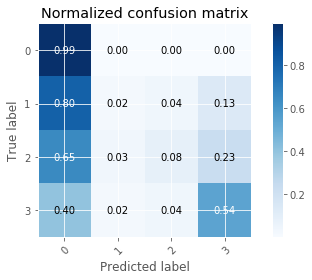

In [15]:
plot_confusion_matrix(y_test, pred, classes=['0','1','2','3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [16]:
df2019 = pd.read_csv("2019 Brownlow Match Data.csv")
df2019 = df2019.iloc[:, :-4]
df2019['Winning_Margin'] = df2019.apply(lambda x: calculate_margin(x), axis=1)
df2019 = df2019.iloc[:, 10:]
df2019.shape

X = df2019.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions' # values not recorded in 2012 data
], axis=1).values

In [17]:
probs = mlp.predict_proba(X)
hard_pred = mlp.predict(X)

In [18]:
df2019_predictions = pd.read_csv("2019 Brownlow Match Data.csv")
df2019_predictions['Predicted_Votes'] = hard_pred.tolist()

In [19]:
# Group by player and sort form high votes to low
results = pd.DataFrame(data = df2019_predictions.groupby(['Year','player_name','Team'])['Predicted_Votes'].sum())
results = results.reset_index()
results = results.sort_values('Predicted_Votes', ascending=False);

# Display the top 20 predicted vote getters for 2016
results.head(n=20)

,Year,player_name,Team,Predicted_Votes
9,2019,Adam Treloar,COLL,29.0
494,2019,Patrick Dangerfield,GEEL,27.0
242,2019,Jack Macrae,WB,24.0
177,2019,Dustin Martin,RICH,19.0
348,2019,Josh Dunkley,WB,18.0
81,2019,Brodie Grundy,COLL,17.0
382,2019,Lachie Neale,BL,17.0
622,2019,Travis Boak,PORT,16.0
303,2019,Jarryd Lyons,BL,16.0
584,2019,Tim Kelly,GEEL,15.0


In [20]:
df2019_predictions['prediction0'] = probs[:,0] # Probably not needed
df2019_predictions['prediction1'] = probs[:,1]
df2019_predictions['prediction2'] = probs[:,2]
df2019_predictions['prediction3'] = probs[:,3]

In [21]:
df2019_predictions.to_csv('2019NeuralNetwork.csv')